# Voltage Pulse Design with CSP: 2 Dots

This tutorial shows how to construct voltage pulses for basic quantum gates using **Constrained Shape Pulse (CSP)** algorithm 
(see [Chapter 4 of Bohdan's thesis](https://uwspace.uwaterloo.ca/handle/10012/17823) for theory).

The outline of each test case is as follows:
1. Constructing a **DotArray** object  
3.  Creating **DesignerCSP** objects, which contains
        the in-built pulse design method

2. Choosing effective parameter **shape functions**

4. Composing **pulse sequences** out of designer objects for a choice of shapes and times


5. Performing **spin density matrix evolution** of a chosen **state** and plotting parameters:
    - fidelity 
    - 1-qubit subspace evolution on the Bloch spheres

The steps above are discussed in detail for a selective qubit rotation.
At the end of the tutorial, the entire effective pulse design and evolution routine is demonstrated for
$\mathrm{SWAP}^k$ and CPHASE gates, and the effects of spin relaxation and dephasing (to be added).


> Necessary imports and default plotting parameters:

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    print(path.parents[1])

    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

c:\QuDiPy


In [2]:
# import os, sys
# sys.path.append(os.path.dirname(os.getcwd()))     # adding parent folder to path

import numpy as np
from matplotlib import pyplot as plt

from qudipy.system import State, DotArray
from qudipy.design import voltage_csp, shapes
from qudipy.design.voltage_csp import DesignerCSP

## 1. Addressing individual spins in the global ESR field
The goal of this section is to demonstrate selective rotation of the 1st 
qubit of a 2-qubit system:

$$  
    Y_1\left(\frac{\pi}{2}\right)
    |\uparrow -\rangle = |+ -\rangle
$$

### 1.1 Constructing a DotArray object

Define the directory to <span style="background-color: Khaki;">store 2D potential slice data</span> extracted from nextnano simulations for a given device, as well as, to  <span style="background-color: Khaki;">store calculated variables</span> such as $g$-factor deviation, exchange, or Hubbard parameters for individual dots or dot pairs.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'tutorials')

In [4]:
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','2QD_processed')

Define the directory location that contains all of the nextnano simulation  <span style="background-color: Khaki;">data files to be processed or imported</span>.

In [5]:
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','2QD_dotsep_60nm')

Define the anticipated number of quantum dots. This variable will determine if dot merger events occur under various voltage configurations.

In [6]:
n_dots = 2

If desired, define control parameters to use when interpolating the potential data from nextnano: must be a subset of the raw data or the full set of raw data. If not specified, the default is to interpolate over all raw data.

> **Note**: These will greatly influence the accuracy of the resultant calculations as well as the run time of the `Dots()` class upon initial data processing.

In [7]:
eff_interp_dims = [6,6,6]
ctrl_vals = [
    np.linspace(0.2, 0.45, eff_interp_dims[0]),
    np.linspace(-0.1, 0.15, eff_interp_dims[1]),
    np.linspace(0.2, 0.45, eff_interp_dims[2])]

The effective parameter interpolation values could be specified by the keyword `eff_interp_dims` instead. 
 This parameters indicates the number(s) of values for each control parameter to use in the interpolator construction. The data  evenly spaced within min-max range of nextnano data). If a single integer is specified, then it determines 
            the # of points / sweep for each control. 
            
> Note: if `ctrl_vals` is specified, it has priority over `eff_interp_dims`

Keyword `'save'=True` allows to save the interpolating object into a pickle (binary) file in the `precalculated_dir`. 
If such a file exists already, it is automatically loaded, and the interpolators
are not evaluated again. This significantly speeds up other calculations.


In [8]:
file_prefix = 'tutorial'


Now, we instantiate a `Dots()` class object instance using the previously defined variables.

In [9]:
# Calculate the effective parameters and/or load the masked potential 
# lanscapes as well as save 2D potential slices to Pre-processed directory
dots = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots.numeric(processed_dir, nextnano_dir, file_prefix)

Loading pre-calculated spin interpolators from
c:\QuDiPy\QuDiPy data\tutorials\processed\2QD_processed\tutorial_spin_data_size_[6 6 6]_from_[ 0.2 -0.1  0.2]_to_[0.45 0.15 0.45].pkl


Giving voltage parameters shorter names for convenient plotting

In [10]:
dots.ctrl_names = ['$V_1$', '$W_1$','$V_2$']

### 1.2. Constructing DesignerCSP objects

`Designer` class and its child `DesignerCSP` handle control parameters that determine time-dependent pulse sequences. 
The following functions are defined in `qudipy.design.voltage_csp` module to conveniently construct DesignerCSP objects for:
-  arbitrary qubit rotations (`rot`), 
- Hadamard gates (`hadamard`),
- $\mathrm{SWAP}^k$ gates (`swapk`), and
- $\mathrm{CPHASE}(\alpha)$ gates (`cphase`),

All `DesignerCSP` objects require these parameters in advance 
to determine the idling state, the rotating frame, and perform a numerical integration: 
-  `init_detuning_guess`: initial guess of voltage configuration `[v_1, w_1, v_2, w_2...]` to find the idling state,
- ___either___ Zeeman field [T] ___or___ ESR central frequency [Hz],
-  `min_length`: shortest anticipated pulse length $T_\mathrm{min}.$

The CSP integration routine finds functions of type
 $$\vec{V}\left(s\right), \vec{W}\left(s\right), \quad s=S\dfrac{T_\mathrm{min}}{T},$$

where $T$ is pulse length, and $S(t)$ is the normalized shape function (see sec. 1.4 for more information). 
$T_\mathrm{min}$ is typically larger than the user-defined value if there are 
additional system constraints (#TODO will be adjusted accordingly). 
Optional parameter $S_\mathrm{max}$ (10 by default) limits the class of shape functions that can be used to compose a pulse. For example, $S_\mathrm{max}=10$ encompasses all Gaussian shapes with $\sigma>0.05$, which is more than enough for most applications.

In [11]:
v_idle_guess = [0.287, 0.0, 0.275]
B_zeeman = 1  # tesla

#### 1.2.1 Using DesignerCSP class constructor

Manually creating a DesignerCSP for a $Z(\pi/2)$ rotation of the first qubit:

In [12]:
test_des = DesignerCSP(dots, [np.pi/2, 0,0,0,0], v_idle_guess, 10e-6, B_zeeman=B_zeeman)

Initial detuning is found to be  [2.81032433e-01 6.43139240e-05 2.81032584e-01]
Start solving system of ODEs
Solution FOUND!


Plotting dependencies $V(s), W(s)$, where $s=S\frac{T_\mathrm{min}}{T}$:

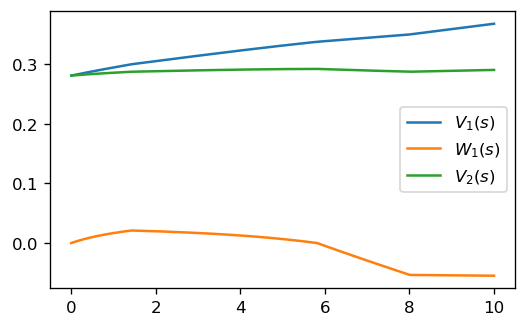

In [13]:
s_steps = np.linspace(0, 10, 1000)
plt.figure(figsize=(5,3), dpi=120)
plt.plot(s_steps, test_des.voltages_of_s(s_steps).T, 
                    label=('$V_1(s)$','$W_1(s)$', '$V_2(s)$'))
plt.legend()
plt.show()

#### 1.2.2 Using shortcut functions (`rot`, `hadamard`, `swapk`, `cphase`)

Building up a designer for synchronous  rotations of the 1st qubit 
in a 2-qubit system by an angle $-3 \pi/8$. 
The cumulative effect of such 4 pulses will give a $-3 \pi/2$ rotation equivalent to $\pi/2$.
Any other combination of angles that gives total angle $\pi/2 \mod 2\pi$ can be used.

The optional parameters in the shortcut functions include:
- `exchange_method`: Heitler-London (`HL`) or Hund-Mulliken (`HM`, default) 
- `rel_diff_step`: differentiation step size relative to the min-max value of control parameter range. Default is $10^{-6}$
-  `masking`: masking method to use for effective parameter evaluation 

In [14]:
v_idle_guess = [0.278, -0.01, 0.275]

rot_des = voltage_csp.rot(dot_array=dots, active_qubits= 1, axis = 'Y', angle = - 3 * np.pi/8, 
                          min_length=6e-6,  init_detuning_guess=v_idle_guess , B_zeeman =B_zeeman,
                                 rel_diff_step=1e-7, masking='harsh')


Initial detuning is found to be  [ 0.27646684 -0.0102404   0.27646696]
Start solving system of ODEs
Solution FOUND!


Alternatively, one can define a Hadamard designer instead that will give the same evolution for the chosen initial state & compose a pulse with it.

In [15]:
# rot_des = effective.hadamard(dot_array=dots, active_qubits= 1, 
#                           min_length=5e-6,
#                                  init_detuning_guess=v_idle_guess , B_zeeman =B_zeeman,
#                                  rel_diff_step=1e-7)

### 1.3 Creating or selecting shape functions

The shape function that defines the effective pulses can be any function of normalized time
with unit expectation value:
$$
    S(\tau): [0,1]\rightarrow \mathbb{R}: \qquad  \langle S \rangle = \int_0^1 S(\tau) \mathrm{d}\tau = 1.
$$

The library of pre-defined shapes includes square, triangular and Gaussian functions. 
They can be either:
- accessed through `qudipy.design.shapes` module, _or_
- specified as 'string keywords' when creating a `ControlPulse` objects (see next)

Defining 4 different shape functions:

In [16]:
unit_square = shapes.square()
unit_triangle = shapes.triangle()
unit_wide_gauss = shapes.gaussian(sigma=0.15)
unit_narrow_gauss = shapes.gaussian(sigma=0.05)

list_shapes = [unit_square, unit_triangle, unit_narrow_gauss, unit_wide_gauss]
list_shapes = [unit_wide_gauss, unit_triangle, unit_narrow_gauss, unit_wide_gauss]


Plotting these shapes:

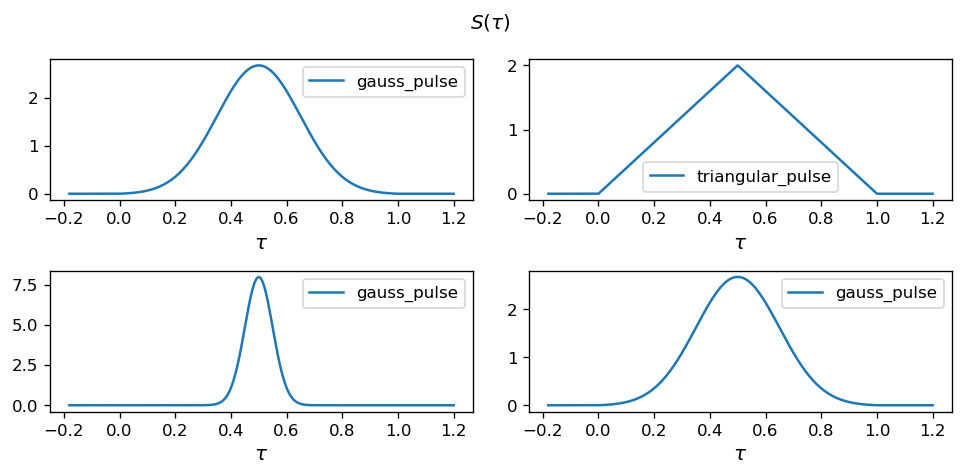

In [17]:
# Normalized time points
tau = np.linspace(-0.18, 1.2, 200)

fig, ax = plt.subplots(2,2, figsize=(8,4), dpi=120)
for i, shape in enumerate(list_shapes):
    ax[i//2, i%2].plot(tau , shape(tau), label=shape.__name__)
    ax[i//2, i%2].legend()
    
    # Setting axes labels.
    ax[i//2, i%2].set_xlabel('$\\tau$', size=12)
    
fig.suptitle('$S(\\tau)$', size=12)
fig.tight_layout()
plt.show()

### 1.4 Composing time-dependent pulses with a DesignerCSP object

Each `DesignerCSP` object is capable of composing time-dependent pulses with different: 
- shapes
- lengths 
- constraints (min/max values of parameters, bandwitdth, etc.)

Below, we compose four `ControlPulse` objects
 with **different shapes** and same length $T=1\mu s$ that correspond to the same $Y_1(-\frac{3\pi}{8})$
operation. 

In [18]:
train_pulses = [rot_des.compose(num_steps=1000, length=7e-6, shape=sh) 
                                                        for sh in list_shapes]

For all effective pulses we design here, 
the physical quantities that could vary over time include:  
- RF magnetic field magnitude `"B_rf"` and phase `"phi"` (in rotation frame)
- Deviation g-factor of the $i^{th}$ electron `"delta_g_{i}"`
- Exchange couplings between the $i^{th}$ and $(j)^{th}$ electrons `"J_{ij}"`

Plotting voltage & effective parameters of the triangular (2nd) pulse (all variables are in SI units):

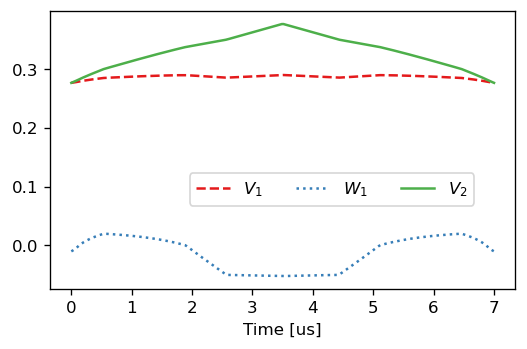

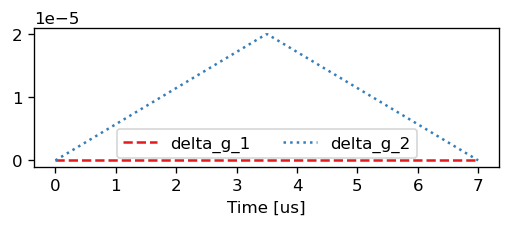

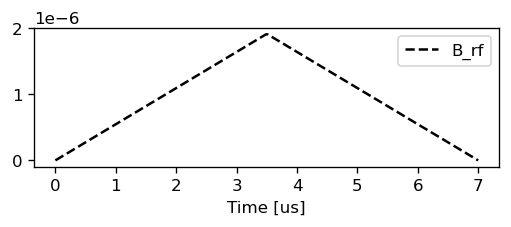

In [19]:
train_pulses[1].plot(plot_ctrls=dots.ctrl_names,figsize= (5,3), loc=(0.3,0.3), ncol=3)
train_pulses[1].plot(plot_ctrls=['delta_g_1', 'delta_g_2'],figsize= (5,1.5))
train_pulses[1].plot(plot_ctrls=['B_rf'], figsize= (5,1.5), color='black')

### 1.5 Evolving spin states under the designed pulses
#### 1.5.1 Defining spin states using `State` class

The  `State`  class from `qudipy.system.state` handles many-electron states in different spaces:
- spin 
- orbital
- valley
- Hubbard (spin + charge)

Currently, only spin states are handled. Defining some basic 1-qubit spin wavefunctions:

In [20]:
psi_up =  np.array([1,0])                           # pure spin up state
psi_down =  np.array([0,1])                         # pure spin down state
psi_plus = 1/np.sqrt(2) * np.array([1,1])           # pure |+> state
psi_minus =  1/np.sqrt(2) * np.array([1,-1])        # pure |-> state

The system of spins is described by the complex density matrix $\rho$ whose evolution is of interest.

Several ways to define the spin state of `State` object are supported through `spin` keyword:
- the density matrix of the whole system: square 2D array;
- the wavefunction (**ket**-vector) of a pure state: row or column vector as 1D/2D array;
- a list/tuple of density matrices, wavefunctions, or both, that describe subsystems constituting the whole system.

The density matrix of the whole system is generated and stored automatically irrespective of the type of input. 

The number of electrons in the system $N$ is inferred from the size of $\rho$; if it changes over time (e.g. due to measurements), the parameter $N_0$ should be specified to indicate the maximal possible electron number. Otherwise, the equality $N=N_0$ is assumed.

The environment parameters that can be specified as State object attributes include:
- temperature (`T` keyword, $0$ K by default)
- $T_1$, $T_2$ times  (`T_1, T_2` keywords, $\infty$ by default).

For now, we assume no dissipation.

In [21]:
# defining states: initial and expected
init_rot = State([psi_up, psi_minus])
exp_rot = State([psi_plus,  psi_minus])

#### 1.5.2 Evolving spin systems

The method `evolve` of a `State` object simulates the system evolution under a given pulse or iterable (tuple or list) of pulses. The iterable could be irregular, like, for example, `[pulse1, pulse2, [pulse3, (pulse4, pulse5)], pulse6]`. It returns a dictionary of 1D arrays of the user-specified parameters that are monitored throughout the simulation:
- Purity of the density matrix 
    - Evaluated when `eval_purity=True` is specified
    - `"purity"` entry in the resultant dictionary  
- Fidelity of the density matrix with respect to the theoretical (initial,expected final, etc.) matrix
    - Evaluated when `eval_fidelity=True` and the reference matrix `rho_reference` are specified
    - `"fidelity"` entry in the resultant dictionary  
- 1-electron density submatrices 
    - Evaluated when a qubit / iterable of qubits to track `track_qubits` is specified
    - `"submatrix_{i}"` entry in the resultant dictionary  
-  Bloch vector components $\langle \sigma_{x} \rangle, \langle \sigma_{y} \rangle, \langle \sigma_{z} \rangle$
    - Evaluated when `eval_Bloch_vectors=True` and an iterable of qubits to track `track_qubits` are specified
    - `"sigma_x_{i}"`,`"sigma_y_{i}"`, `"sigma_z_{i}"` entries in the resultant dictionary  
    
The other entry in the final dictionary, `"time"`, incorporates all points in time during the simulation.

An optional parameter `track_points_per_pulse` could be used to record only a part of the parameter values during the pulse to save memory (default is 100). In particular, it could be equated to 2 if one wants to record only the parameters before and after each pulse.

You can monitor the system evolution with the progress bars. If the system evolves under a sequence of pulses, the bars appear for each of them individually.

Here, we evolve system under four $\pi/8$ pulses with different shapes designed above to obtain a $\pi/2$ rotation.


In [22]:
# defining states: initial and expected
init_rot = State([psi_up, psi_minus])
exp_rot = State([psi_plus,  psi_minus])

In [23]:
rot_data = init_rot.evolve(train_pulses, rho_reference= exp_rot.rho_spin,
                           track_qubits=(1,2), eval_fidelity=True,
                                    eval_Bloch_vectors=True)

ROTY-67.50° 1, step 1000: 100%|██████████| 1000/1000 [00:02<00:00, 367.95it/s]


Plotting evolution results

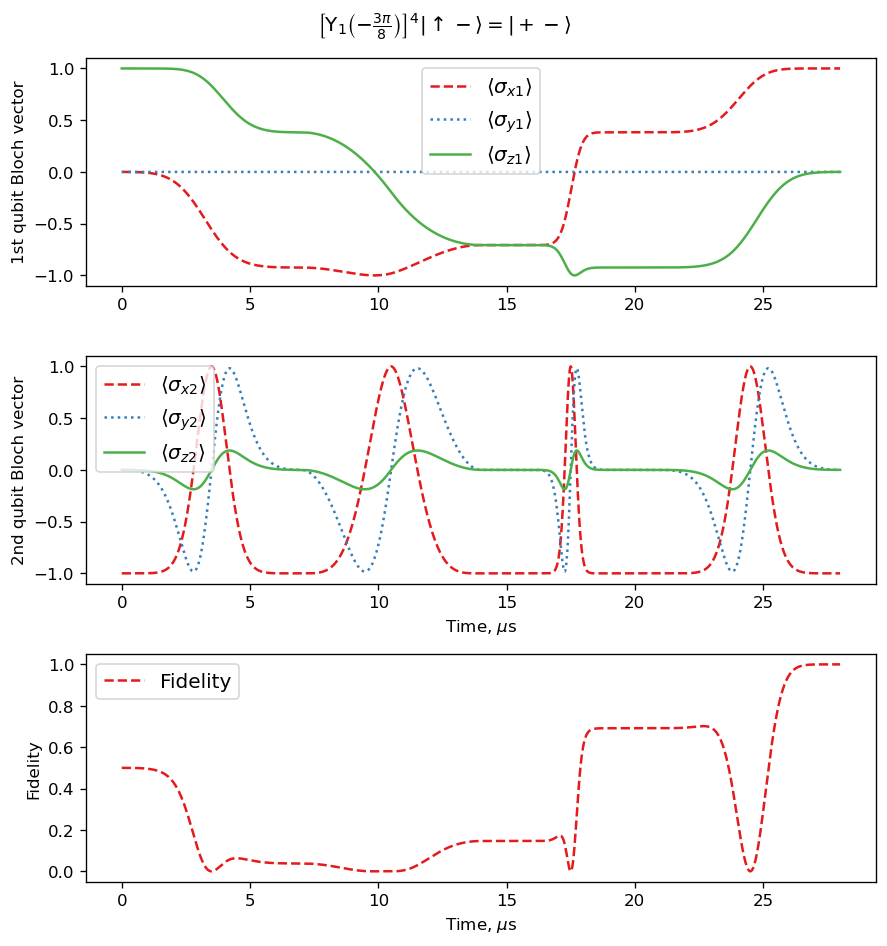

In [24]:
%matplotlib inline

fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend( fontsize="large")

############

ax[2].plot(rot_data["time"] * 1e6, 
         np.real(rot_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, $\mu$s")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left[\\mathrm{Y}_{1}\\left(-\\frac{3\\pi}{8}\\right)\\right]^4$'
             '$ |\\uparrow -\\rangle = |+ -\\rangle$')
plt.tight_layout()
plt.show()

Note the $2\pi$ rotations around skewed axes that non-resonant qubit #3 goes through to preserve 
its initial states after each pulse.

Infidelity at the end:

In [25]:
1- rot_data['fidelity'][-1]

-1.5727517510555344e-08

## 2. $\mathrm{SWAP}^k$ two-qubit gates

This and the following sections show how to quickly run everything altogether: state definition, pulse design, and state evolution.

Testing the operation $\mathrm{SWAP}_{12} |+ \uparrow -\rangle = |\uparrow + -\rangle$ with 
four $\mathrm{SWAP}^{1/4}$ pulses of different lengths.


> DesignerCSP objects for $\mathrm{SWAP}^{1/4}$ pulses

In [26]:
v_idle_guess = [0.26, 0.01, 0.267]

swap_des = voltage_csp.swapk(dot_array=dots, qubit_pairs= (1,2),
                                 k=1/4, min_length=1e-9,
                                 init_detuning_guess=v_idle_guess, 
                                 B_zeeman =  B_zeeman)

Initial detuning is found to be  [0.26353872 0.01021341 0.26353921]
Start solving system of ODEs
Solution FOUND!


> Composing pulses with **different lengths** $T = 1, 2, 5, 10$ ns 
> and same shape (gaussian with $\sigma=0.2$)

In [27]:
train_swap_pulses = [swap_des.compose(num_steps = 1000, shape='Gaussian', sigma=0.1, length=T) 
                            for T in [1e-9, 2e-9, 5e-9, 1e-8]]

> Plotting one of the voltage pulses 

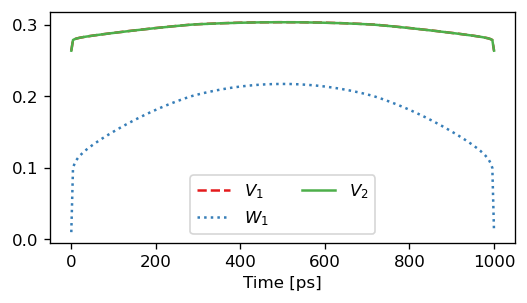

In [28]:
train_swap_pulses[0].plot(plot_ctrls=swap_des.dot_array.ctrl_names)


> Defining initial and expected spin states:

In [29]:
init_swap = State(spin=[psi_plus, psi_up, psi_minus])
exp_swap = State(spin=[psi_up, psi_plus, psi_minus])

> Evolving qubit state, plotting fidelity and Bloch vectors

In [30]:
swap_data = init_swap.evolve(train_swap_pulses, rho_reference=exp_swap.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2,3),
                                    eval_Bloch_vectors=True)

SWAP^0.25 (1, 2), step 1000: 100%|██████████| 1000/1000 [00:04<00:00, 235.15it/s]


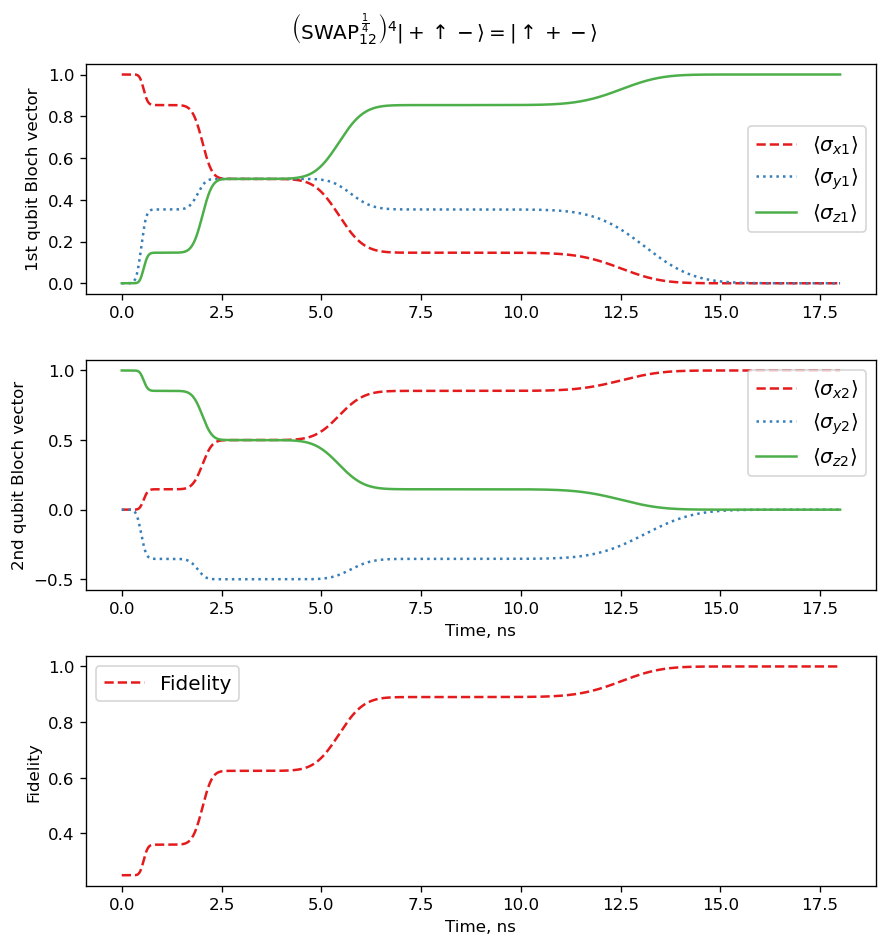

In [31]:
fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, ns")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(fontsize="large")

############

ax[2].plot(swap_data["time"] * 1e9, 
         np.real(swap_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, ns")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left(\\mathrm{SWAP}^{\\, \\frac{1}{4}}_{12}\\right)^4 \
             |+ \\uparrow -\\rangle = |\\uparrow + -\\rangle$')
plt.tight_layout()
plt.show()

Infidelity at the end:

In [32]:
1- swap_data['fidelity'][-1]

7.993605777301127e-15

## 3. $\mathrm{CPHASE}(\alpha)$ two-qubit gates


Running a control-Z operation:

 $$\mathrm{CZ}_{12} | + \downarrow \rangle = | - \downarrow\rangle$$ 

We represent each gate control-Z gate as a combination of two control-phase gates:
$$
    \mathrm{CZ} = \mathrm{CPHASE}(\pi) = \mathrm{CPHASE}(\pi/3) \mathrm{CPHASE}(2\pi/3)
$$

> Initial and expected states:

In [33]:
init_cz = State(spin=[ psi_plus, psi_down])
exp_cz = State(spin=[ psi_minus, psi_down])

> Two DesignerCSP objects for $\mathrm{CPHASE}$ pulses. 
> Specifying all parameters, including shapes and times, right away this time

In [34]:
cphase_pi3_des = voltage_csp.cphase(dots, [(1,2)], angle = np.pi/3,
                                  init_detuning_guess =v_idle_guess, 
                                 B_zeeman =  B_zeeman, 
                                 rel_diff_step=1e-7,
                                  min_length = 9e-6)
                                  
cphase_2pi3_des = voltage_csp.cphase(dots, [(1,2)], angle = 2* np.pi/3, 
                                  init_detuning_guess = v_idle_guess,   
                                  B_zeeman = B_zeeman,
                                 rel_diff_step=1e-7,
                                        min_length = 9e-6)

Initial detuning is found to be  [0.26353872 0.01021341 0.26353921]
Start solving system of ODEs
Solution FOUND!
Initial detuning is found to be  [0.26353872 0.01021341 0.26353921]
Start solving system of ODEs
Solution FOUND!


> Composing corresponding pulses 

In [35]:
cphase_pulses = [cphase_pi3_des.compose(num_steps = 1000, shape='gaussian', 
                                                length = 1.2e-5, sigma=0.25 ), 
                        cphase_2pi3_des.compose(num_steps = 1000, 
                                    length =  1.2e-5, shape='triangle' )]
                                    


> Plotting the first pulse

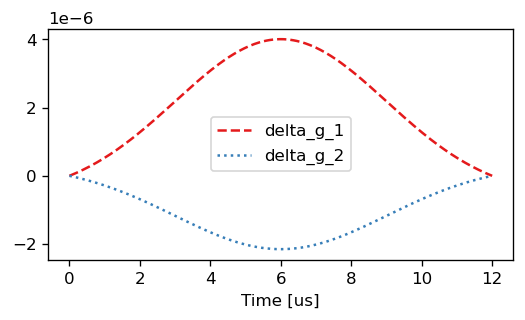

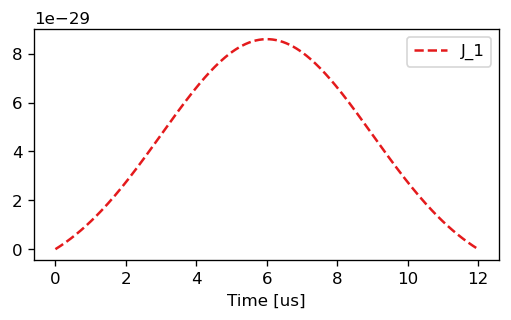

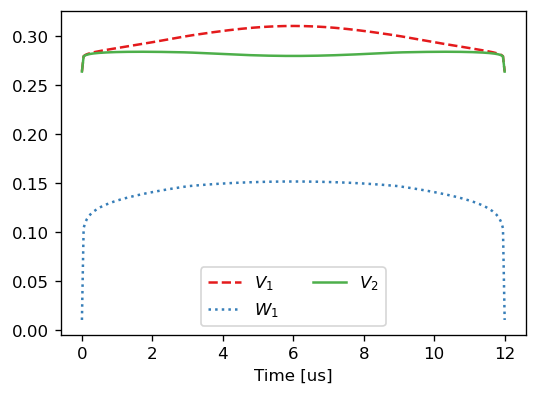

In [36]:
cphase_pulses[0].plot(plot_ctrls=['delta_g_1', 'delta_g_2'], ncol=1)
cphase_pulses[0].plot(plot_ctrls=['J_1'])
cphase_pulses[0].plot(plot_ctrls=dots.ctrl_names, figsize=(5,3.5))

> Evolving qubit state, plotting fidelity and Bloch vectors

In [37]:
cphase_data = init_cz.evolve(cphase_pulses, rho_reference=exp_cz.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2), 
                                    eval_Bloch_vectors=True)

CPHASE(120.00°) (1, 2), step 1000: 100%|██████████| 1000/1000 [00:02<00:00, 401.52it/s]


Plotting Bloch vector evolution of the qubits 1,2,3

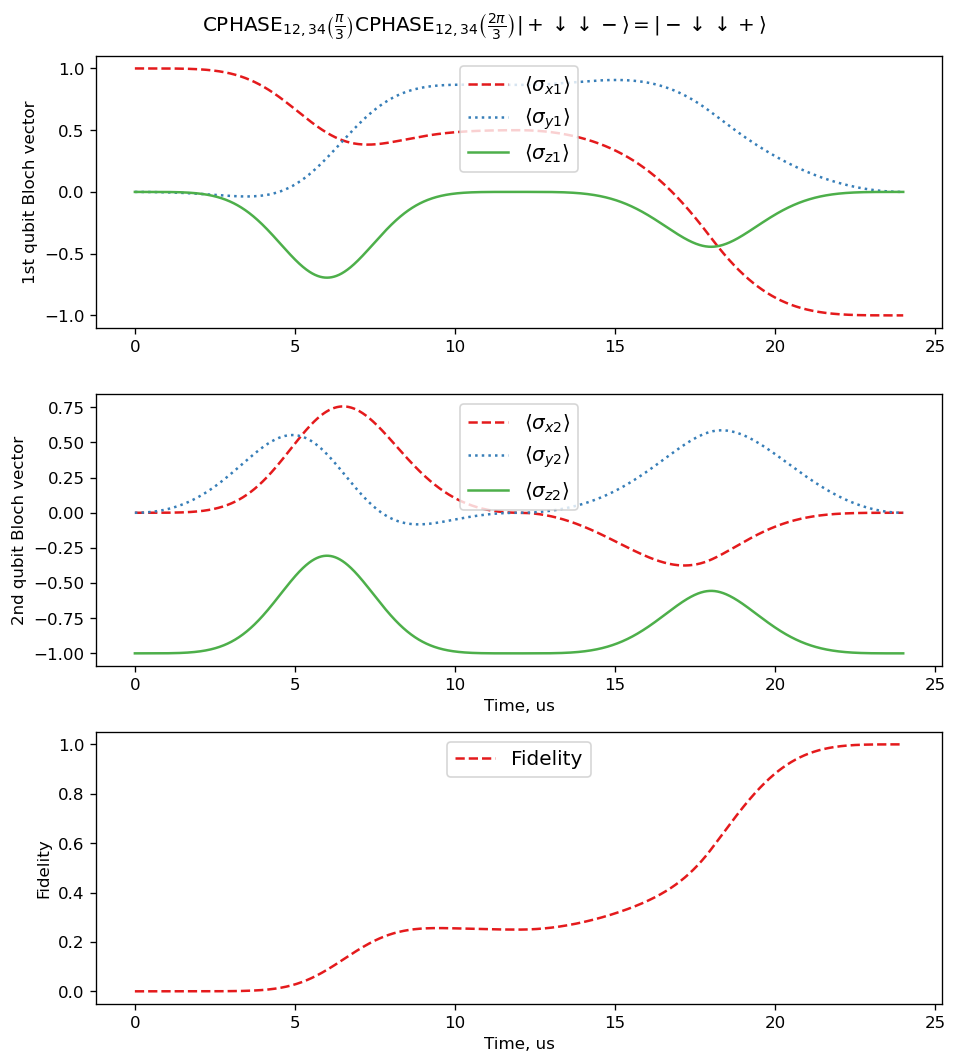

In [38]:
fig, ax = plt.subplots(3,1, dpi=120, figsize=(8,9) )

ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend(loc='upper center',  fontsize="large")

###############################

ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, us")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(loc='upper center', fontsize="large")



ax[2].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, us")
ax[2].set_ylabel("Fidelity")

ax[2].legend(loc='upper center', fontsize="large")

fig.suptitle('$\\mathrm{CPHASE}_{12, 34}\\left(\\frac{\\pi}{3}\\right)$'
             '$ \\mathrm{CPHASE}_{12, 34}\\left(\\frac{2\\pi}{3}\\right) $'
             '$| + \\downarrow\\downarrow - \\rangle = |- \\downarrow\\downarrow + \\rangle$')

plt.tight_layout()
plt.show()

Inidelity at the end:

In [39]:
1-cphase_data['fidelity'][-1]

6.167732991002595e-12